# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [3]:
from backend import data_paths
from backend import gauge_groups_utils
from backend import loading_utils
from backend import evaluation_utils

# Metadata

## Gauge Groups

### Full Gauge Group

In [4]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


### Ungauged Gauge Groups

In [5]:
gauge_groups = gauge_groups_utils.load_all_ungauged_gauge_groups()
print(f'There are {len(gauge_groups)} sets of ungauged gauge groups.')

Working on kfold_splits ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 6621.89it/s]


Working on continent_splits ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3013.51it/s]


Working on climate_splits ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 5131.37it/s]

There are 3 sets of ungauged gauge groups.


### GloFAS v4 Calibration Gauge Group

In [6]:
# Read GloFAS Metadata file.
glofas_v4_metadata = loading_utils.load_glofas_v4_calibration_metadata_file()
glofas_v4_gauges = [gauge for gauge in glofas_v4_metadata.index]

# Find gauge group intersection.
calibration_v4_gauges = list(set(gauges).intersection(glofas_v4_gauges))
print(f'There are {len(calibration_v4_gauges)} v4 benchmarking gauges.')

There are 1144 v4 benchmarking gauges.


### Test Gauges

In [7]:
glofas_metadata = loading_utils.load_glofas_v4_metadata_file()
glofas_gauges = list(set(glofas_metadata.index).intersection(set(gauges)))
print(f'There are {len(glofas_gauges)} GloFAS gauges.')

There are 4089 GloFAS gauges.


## Gauge Locations

In [8]:
latlon = loading_utils.load_attributes_file(
    attributes=['latitude', 'longitude']
)

# Record Lengths Map

In [9]:
record_lengths_df = loading_utils.load_grdc_record_length_file()

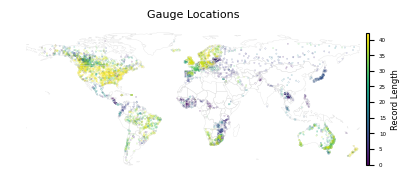

In [20]:
fig, ax = plt.subplots(
    1, 1, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['one_half_column'], 
        evaluation_utils.LATITIDE_FIG_SCALER * evaluation_utils.NATURE_FIG_SIZES['one_half_column']
    )
)

evaluation_utils.spatial_plot(
    record_lengths_df,
    latlon=latlon,
    metric='Record Length',
    vmin=0,
    vmax=42,
    title='Gauge Locations',
    ms=0.01,
    ax=ax
)

evaluation_utils.save_figure(data_paths.ALL_GAUGE_LOCATIONS_MAP_FIGURE_FILENAME)

# Cross Validation Split Maps

In [27]:
def show_map_of_classes(
    sample_merged_df: pd.DataFrame,
    attributes: pd.DataFrame, 
    column_name: str, 
    title: str, 
    colorbar: bool, 
    cmap: str,
    metric: str,
    ms: int = 0.01,
    ax: plt.Axes = None
):
    
    values_for_color = sample_merged_df[column_name].values
    values_for_color_to_color_num = {v: i + 1 for i, v in enumerate(sorted(set(values_for_color)))}
    actual_colors = np.array([values_for_color_to_color_num[x] for x in values_for_color])
    integer_df = sample_merged_df.copy()
    for val, i in values_for_color_to_color_num.items():
        integer_df.loc[integer_df[column_name] == val, column_name] = i
        
    ax = evaluation_utils.spatial_plot(
        integer_df[column_name],
        latlon=attributes,
        metric=metric,
        vmin=0.1,#actual_colors.min(),
        vmax=actual_colors.max(),
        title=title,
        colorbar=colorbar,
        cmap=cmap,
        ax=ax,
        ms=ms,
    )
    
    return ax

In [28]:
split_df = pd.DataFrame(
    index=gauges,
    columns=data_paths.UNGAUGED_EXPERIMENTS,
    dtype=str
)

for experiment in data_paths.UNGAUGED_EXPERIMENTS:
    for name, gg in gauge_groups[experiment].items():
        split_df.loc[gg, experiment] = name

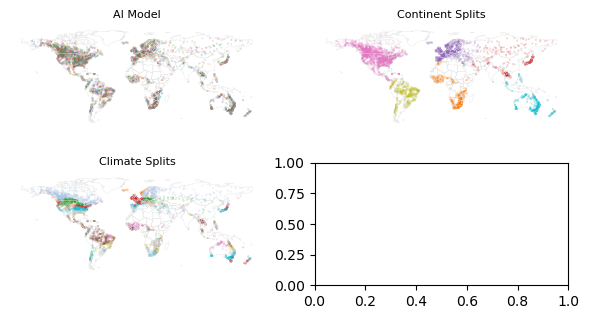

In [29]:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['two_column'], 
        evaluation_utils.LATITIDE_FIG_SCALER * evaluation_utils.NATURE_FIG_SIZES['two_column']
    )
)
cmap_mapping = {exp: 'tab10' for exp in data_paths.UNGAUGED_EXPERIMENTS}
cmap_mapping['climate_splits'] = 'tab20'

for ax, experiment in zip(axes.flatten(), data_paths.UNGAUGED_EXPERIMENTS):
    show_map_of_classes(
        split_df,
        latlon,
        column_name=experiment, 
        title=evaluation_utils.EXPERIMENT_NAMES[experiment], 
        colorbar=False, 
        cmap=cmap_mapping[experiment],
        metric=experiment,
        ax=ax
    )

evaluation_utils.save_figure(data_paths.CROSS_VALIDATION_SPLITS_MAP_FIGURE_FILENAME)

# Calibration / Validation Gauges Map

In [25]:
calval_df = pd.DataFrame(
    index=gauges,
    columns=['cal_val'],
    dtype=str
)

# Assign categories to each gauge.
for gauge in tqdm.tqdm(gauges):
    if gauge in calibration_v4_gauges:
        calval_df.loc[gauge, 'cal_val'] = 'calibration'
    elif gauge in glofas_gauges:
        calval_df.loc[gauge, 'cal_val'] = 'validation'
    else:
        calval_df.loc[gauge, 'cal_val'] = 'training'

# Add this so that we use the first three colors of the color mapping.        
for i in range(7):
    calval_df.loc[f'unused{i}', 'cal_val'] = f'x_{str(i)}'
    
evaluation_utils.save_figure(data_paths.CROSS_VALIDATION_SPLITS_MAP_FIGURE_FILENAME)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5678/5678 [00:00<00:00, 9473.71it/s]


<Figure size 640x480 with 0 Axes>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


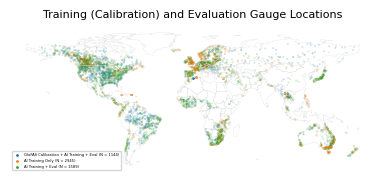

In [40]:
fig, ax = plt.subplots(
    1, 1, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['one_half_column'], 
        evaluation_utils.LATITIDE_FIG_SCALER * evaluation_utils.NATURE_FIG_SIZES['one_half_column']
    )
)

show_map_of_classes(
    calval_df,
    latlon,
    column_name='cal_val', 
    title='Training (Calibration) and Evaluation Gauge Locations', 
    colorbar=False, 
    cmap='tab10',
    metric='cal_val',
    ax=ax
)

labels = [
    f'GloFAS Calibration + AI Training + Eval',
    f'AI Training Only',
    f'AI Training + Eval',
]
for i, group in enumerate(['calibration', 'validation', 'training']):
    first_gauge_in_group = calval_df.loc[calval_df['cal_val'] == group].index[0]
    plt.scatter(
        x=latlon.loc[first_gauge_in_group, 'longitude'],
        y=latlon.loc[first_gauge_in_group, 'latitude'],
        c=evaluation_utils.COLORS[i],
        label=labels[i] + f' (N = {calval_df.loc[calval_df["cal_val"] == group].shape[0]})',
        s=1
    )
plt.legend(
    loc='lower left',
    fontsize=2.7
)

evaluation_utils.save_figure(data_paths.CALVAL_GAUGE_LOCATIONS_MAP_FIGURE_FILENAME)